In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [651]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Important: Load Directories Here
Source the local directory below.


In [0]:
user= "victor"

if user=="jordan": 
  drive_dir= 'drive/My Drive/CIS519 Project Folder/Project'
elif user=="victor":
  drive_dir= 'drive/My Drive/CIS519 Project Folder/Project'

# Section 1: Imports and File Processing


In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as tmodels
import math

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
from PIL import Image
import os
import pandas as pd
import re
import matplotlib.pyplot as plt

import itertools
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [654]:
num_classes= 5
class_names= ['anger' , 'disgust', 'happy', 'sad', 'surprise']
ds_store= "_DS_Store"

use_gpu = torch.cuda.is_available()
if use_gpu:
	print ('USE GPU')
else:
	print ('USE CPU')

USE GPU


In [0]:
def pre_process(ckanade= 'ckanade.csv', ckanade_mapping= 'ckanade-mapping.csv', firstrun= False):
    ckanade= drive_dir + "/" + ckanade
    ckanade_mapping= drive_dir + "/" + ckanade_mapping
    if firstrun:  
        df= pd.read_csv(ckanade)
        df['facs_split']= np.nan
        df['label']= np.nan
        mydict= {}
        for i in range(df.shape[0]):
            facs_str= re.sub('[a-z]*[A-Z]*', '', df['facs'][i])
            print(facs_str)
            facs_split= facs_str.split('+')
            facs_split= [int(x) for x in facs_split]
            df['facs_split'][i]= str(facs_split)
            label= -1
            if 23 in facs_split and 24 in facs_split:
                label= 0 #anger
            elif 9 in facs_split or 10 in facs_split: 
                label= 1 #disgust
            elif 1 in facs_split and 2 in facs_split and 3 in facs_split: 
                label= 2 #fear
            elif 12 in facs_split: 
                label= 3 #happy
            elif (1 in facs_split and 4 in facs_split and 15 in facs_split)\
                 or 11 in facs_split: 
                     label= 4 #sad
            elif (1 in facs_split and 2 in facs_split) or 5 in facs_split: 
                label= 5 #surprise
            elif (14 in facs_split):
                label= 6 #contempt
            df['label'][i]= label
            mydict[(df['subjectno'][i], df['sessionno'][i])]= label
    
            df= df[df['label']!=-1].reset_index()
            df.to_csv(ckanade_mapping, index=False)
            mydict= {(df['subjectno'][i], df['sessionno'][i]): df['label'][i] for i in range(df.shape[0])}
            return (df, mydict)
    else: 
        df= pd.read_csv(ckanade_mapping)
        mydict= {(df['subjectno'][i], df['sessionno'][i]): df['label'][i] for i in range(df.shape[0])}
        return (df, mydict)
    

def extract_data(x_data_filepath, y_data_filepath):
    X = np.load(x_data_filepath)
    y = np.load(y_data_filepath)
    return X, y


def show_images(img):
    image = Image.open(img)
    image.show()


# Returns a list of np array representations of images
# directory should be "men/women"
def images_to_np(directory, mydict, scale= 1/5, verbose= False, peakexpression= True):
    allimages= []
    labels= []

    for people in os.listdir(directory): 
        if people == ds_store:
            continue
        for emotion in os.listdir(os.path.join(directory, people)):
            if emotion == ds_store:
                continue
            key= (int(people[1:]), int(emotion))
            #if emotion is identifiable...
            if key in mydict.keys(): 
                filelist= os.listdir(os.path.join(directory, people, emotion))
                if peakexpression: 
                    filelist= filelist[-5:]
                for file in filelist:
                    if file == ds_store:
                        continue
                    fullpath= os.path.join(directory, people, emotion, file)
                    img = Image.open(fullpath)
                    img.load()
                    img = img.resize((int(640* scale), int(490* scale)), Image.ANTIALIAS)
                    data = np.asarray( img, dtype="int32")
                    if(data.flatten().shape[0]%(int(640 * scale)*int(490* scale)) == 0):
                        data = data.reshape(int(640 * scale)*int(490* scale), -1)
                        data = np.mean(data, axis= 1)
    
                        if verbose: 
                            #print("%s\n" % str(data.shape))
                            labels.append(mydict[key])
                            allimages.append(data)
                            if verbose: 
                                print("%s %d" % (fullpath, mydict[key]))
                    else: 
                        if verbose: 
                            print("excluded: %s" % fullpath)
    return np.array(labels), np.array(allimages)



def prepare_data(train_dir, test_dir, scale= 1/5, firstrun= False, test_y= 'test_y.npy',
                 test_x= 'test_x.npy', train_y= 'train_y.npy', train_x= 'train_x.npy',
                 largeset= False):
    if largeset: 
        test_y= drive_dir + "/large images/"  + test_y
        test_x= drive_dir + "/large images/" + test_x
        train_y= drive_dir + "/large images/" + train_y
        train_x= drive_dir + "/large images/" + train_x
        train_dir= drive_dir + "/large images/" + train_dir
        test_dir= drive_dir + "/large images/" + test_dir 
    else: 
        test_y= drive_dir + "/" + test_y
        test_x= drive_dir + "/" + test_x
        train_y= drive_dir + "/" + train_y
        train_x= drive_dir + "/" + train_x
        train_dir= drive_dir + "/" + train_dir
        test_dir= drive_dir + "/" + test_dir
    
    if firstrun: 
        df, mydict= pre_process()
        
        print("TRAIN dir: %s" %(train_dir))
        trainy, trainx= images_to_np(train_dir, mydict, verbose= True, peakexpression= True)
        
        print("TEST dir: %s" %(test_dir))
        testy, testx= images_to_np(test_dir, mydict, verbose= True, peakexpression= True)
        
        #save training data
        np.save('%s/train_y.npy' %drive_dir, trainy)
        np.save('%s/train_x.npy'%drive_dir, trainx)
        
        #save testing data
        np.save('%s/test_y.npy'%drive_dir, testy)
        np.save('%s/test_x.npy'%drive_dir, testx)
        
    else: 
        testy= np.load(test_y)
        testx= np.load(test_x)
        trainy= np.load(train_y)
        trainx= np.load(train_x)
    return (testy, testx, trainy, trainx)





In [0]:
def gray_to_color(np_arr):
  np_arr2= np.append(np_arr, np_arr, axis= 1)
  np_arr2= np.append(np_arr2, np_arr, axis= 1)
  return np_arr2

In [0]:
def add_noise_data(np_arr, np_y, n=2, r= 10): 
  for i in range(n):
    random= np.random.randint(r, size= (np_arr.shape[0],np_arr.shape[1])) - 0.5*r
    random= np_arr+ random
    np_arr= np.append(np_arr, random, axis= 0)
    np_y= np.append(np_y, np_y)
  
  print(np_arr.shape)
  print(np_y.shape)
  return np_arr, np_y
  
  

# Section 2: Neural Networks

In [0]:
#%% NEURAL NETWORKS
class Dataset(Dataset):
    """CIFAR-10 image dataset."""
    def __init__(self, X, y, transformations=None):
        self.len = len(X)           
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).long()
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [0]:
#Reference: from
#https://pytorch.org/docs/0.4.0/_modules/torchvision/models/alexnet.html
class MiniNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(MiniNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 200, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(200, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(8960, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
#Reference: from
#https://pytorch.org/docs/0.4.0/_modules/torchvision/models/alexnet.html
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1536, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 1536)
        x = self.classifier(x)
        return x

In [0]:
class ClassCNN(nn.Module):
    def __init__(self):
        super(ClassCNN, self).__init__()
        self.conv1= nn.Conv2d(1, 7, 3, stride= 1, padding= 0)
        self.pool= nn.MaxPool2d(2 , 2)
        self.conv2= nn.Conv2d(7, 16, 3, stride= 1, padding= 0)
        self.fc1= nn.Linear(44896, 1000)
        self.fc2= nn.Linear(1000, 500)
        self.fc3= nn.Linear(500, 100)
        self.d3= nn.Dropout(p= 0.3)
        self.fc4= nn.Linear(100, 10)
        

    def forward(self, x):
        x= F.relu(self.conv1(x))
        x= self.pool(x)
        x= F.relu(self.conv2(x))
        x= x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x= self.d3(x)
        x= F.sigmoid(self.fc4(x))
        return x 

In [0]:
#supports dataframe implementations
def run_epochs(df, train_load, test_load, net, criterion, optimizer,
               max_epochs= 100, verbose= True):    
    
    for epoch in range(max_epochs):
        if verbose: 
            print("Epoch:", epoch)

        train_c= 0
        train_t= 0

        test_c= 0
        test_t= 0

        for i, data in enumerate(train_load, 0):
            inputs, labels= data
            inputs, labels= Variable(inputs), Variable(labels)
            
            if use_gpu: 
              inputs= inputs.cuda()
              labels= labels.cuda()

            #feed inputs into network
            y_pred = net(inputs)
            loss= criterion(y_pred, labels)

            #zero gradient
            optimizer.zero_grad()

            #backprop
            loss.backward()

            #weight update
            optimizer.step()

            #after updating... report training accuracy
            pred= net(inputs)
            t_loss= criterion(pred, labels)
            _, pred= torch.max(pred, 1)
            train_c= train_c + int((pred==labels).sum())
            train_t = train_t + labels.size(0)

        for i, data in enumerate(test_load, 0):
            inputs, labels= data
            inputs, labels= Variable(inputs), Variable(labels)
            
            if use_gpu: 
              inputs= inputs.cuda()
              labels= labels.cuda()

            pred= net(inputs)
            _, pred= torch.max(pred, 1)
            
            finalpred= pred
            finallabels= labels
            test_c= test_c + int((pred==labels).sum())
            test_t= test_t + labels.size(0)
        df['Train Accuracy'][epoch]= (train_c/train_t)
        df['Test Accuracy'][epoch]= (test_c/test_t)
        df['Loss'][epoch]= t_loss.item()
        print("Train Acc:", (train_c/train_t), "Test Acc:", (test_c/test_t), "Loss:", t_loss.item())
    
    return (df, pred, labels)

#%%
def printheader(string):
    print("=================%s===============" %(string))
    

def plot_fig(df, savename= "figure.png", title= "Figure"): 
    
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(range(max_epochs), df['Train Accuracy'].tolist(), label= "Train Accuracy")
    ax1.plot(range(max_epochs), df['Test Accuracy'].tolist(), label= "Test Accuracy")
    ax1.legend()
    
    ax2.plot(range(max_epochs), df['Loss'], label= "Loss", color= "black")
    ax2.legend()
    plt.savefig(savename)
    

#source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, savename,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)

# Section 3: Main Code Body

# Hyper-parameter Testing
Below is the Code for hyper-parameter testing. Do not run this code if not testing. 

In [666]:
#%% Main code body
run= True
if run:
    learning_rate= 0.00005
    loc= "data"
    batch_size= 100
    max_epochs= 100
    scale= 1/5
    graytocolor= False

    h_testing= True

    printheader("Part 1. Loading Data")
    train_dir= "Emotion Data/women"
    test_dir= "Emotion Data/men"




    #for google drive only
    test_y, test_x, train_y, train_x = prepare_data(train_dir, test_dir, largeset= False)


    unique, counts = np.unique(test_y, return_counts=True)
    testzip = dict(zip(unique, counts))
    
    
    unique, counts = np.unique(train_y, return_counts=True)
    trainzip = dict(zip(unique, counts))
    
    
    print(testzip)
    print(trainzip)
    
    print("hello")

=================Part 1. Loading Data===============
{0.0: 15, 1.0: 35, 2.0: 62, 3.0: 20, 4.0: 70}
{0.0: 105, 1.0: 160, 2.0: 360, 3.0: 155, 4.0: 295}
hello


(753, 12544)
(322, 12544)
=================Part 2. Preparing Network===============
=================Part 3. Running Network===============
Epoch: 0
Train Acc: 0.29747675962815406 Test Acc: 0.2484472049689441 Loss: 2.2757320404052734
Epoch: 1
Train Acc: 0.301460823373174 Test Acc: 0.2546583850931677 Loss: 1.7463968992233276
Epoch: 2
Train Acc: 0.2908366533864542 Test Acc: 0.2360248447204969 Loss: 1.6978001594543457
Epoch: 3
Train Acc: 0.3559096945551129 Test Acc: 0.2701863354037267 Loss: 1.2930713891983032
Epoch: 4
Train Acc: 0.35325365205843295 Test Acc: 0.2546583850931677 Loss: 1.355975866317749
Epoch: 5
Train Acc: 0.3891102257636122 Test Acc: 0.2950310559006211 Loss: 1.5218250751495361
Epoch: 6
Train Acc: 0.41434262948207173 Test Acc: 0.2701863354037267 Loss: 1.2478137016296387
Epoch: 7
Train Acc: 0.4648074369189907 Test Acc: 0.2701863354037267 Loss: 1.205883502960205
Epoch: 8
Train Acc: 0.49269588313413015 Test Acc: 0.30434782608695654 Loss: 1.1334187984466553
Epoch: 9
Train Acc: 0

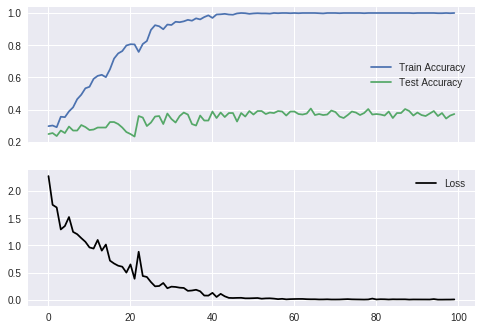

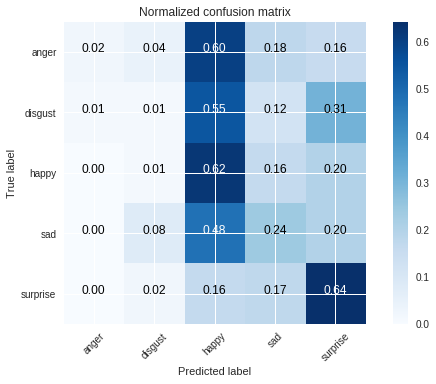

=================Part 3. Running Network===============
Epoch: 0
Train Acc: 0.25232403718459495 Test Acc: 0.19254658385093168 Loss: 2.7328381538391113
Epoch: 1
Train Acc: 0.3200531208499336 Test Acc: 0.2701863354037267 Loss: 1.8546634912490845
Epoch: 2
Train Acc: 0.31341301460823373 Test Acc: 0.2453416149068323 Loss: 1.718468189239502
Epoch: 3
Train Acc: 0.31208499335989376 Test Acc: 0.2732919254658385 Loss: 1.6329119205474854
Epoch: 4
Train Acc: 0.3665338645418327 Test Acc: 0.2577639751552795 Loss: 1.521033525466919
Epoch: 5
Train Acc: 0.3705179282868526 Test Acc: 0.2639751552795031 Loss: 1.377267837524414
Epoch: 6
Train Acc: 0.3598937583001328 Test Acc: 0.2515527950310559 Loss: 1.2912182807922363
Epoch: 7
Train Acc: 0.38114209827357237 Test Acc: 0.2919254658385093 Loss: 1.3850380182266235
Epoch: 8
Train Acc: 0.41434262948207173 Test Acc: 0.2236024844720497 Loss: 1.2016594409942627
Epoch: 9
Train Acc: 0.4395750332005312 Test Acc: 0.2701863354037267 Loss: 1.1352534294128418
Epoch: 10
T

KeyboardInterrupt: ignored

In [638]:
#%% Main code body
run= False
if run:
    learning_rate= 0.00005
    loc= "data"
    batch_size= 100
    max_epochs= 100
    scale= 1/5
    graytocolor= False

    h_testing= True

    printheader("Part 1. Loading Data")
    train_dir= "Emotion Data/women"
    test_dir= "Emotion Data/men"




    #for google drive only
    test_y, test_x, train_y, train_x = prepare_data(train_dir, test_dir, largeset= False)


    print(train_x.shape)
    print(test_x.shape)
if run:
    h_testing= True
    
      
    #for hyperparameter testing only
    if h_testing:
      t= int(0.3*train_y.shape[0])
      test_y= train_y[:t]
      test_x= train_x[:t]
      train_y= train_y[t:]
      train_x= train_x[t:]
    else: 
      test_y, test_x= shuffle(test_y, test_x, random_state=0)
      train_y, train_x= shuffle(train_y, train_x, random_state=0)

    #train_x, train_y= add_noise_data(train_x, train_y)
    
    print(train_x.shape)
    print(test_x.shape)



    printheader("Part 2. Preparing Network")
    df= pd.DataFrame(index= range(max_epochs), columns= ['Train Accuracy', 'Test Accuracy', 'Loss'])


    params= {'batch_size': batch_size}    

    train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
    test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

    #true iff resnet50
    if graytocolor: 
      train_x= gray_to_color(train_x)
      test_x= gray_to_color(test_x)
      
      
    for learning_rate in [0.0001, 0.00005, 0.00001]:
        params= {'batch_size': batch_size}    

        train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
        test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

        #true iff resnet50
        if graytocolor: 
          train_x= gray_to_color(train_x)
          test_x= gray_to_color(test_x)


        #specify network
        net= MiniNet()

        if use_gpu: 
          net= net.cuda()

        #define training dataset
        train_set= Dataset(X= train_x, y= train_y)
        train_load= DataLoader(train_set, **params)

        #define test set
        test_set= Dataset(X= test_x, y= test_y)
        test_load= DataLoader(test_set, batch_size= test_y.shape[0])


        #specify loss
        criterion= nn.CrossEntropyLoss()


        #specify optimization
        optimizer= optim.Adam(net.parameters(), lr= learning_rate)

        printheader("Part 3. Running Network")

        #uncomment below to run
        df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer)
        df.to_csv("%s/output/mininet_learning_rate_%d.csv"%(drive_dir, learning_rate * 1000000))

        printheader("Part 4. Plotting Data")
        plot_fig(df, savename= "%s/output/mininet_plotlr%d.png"%(drive_dir, learning_rate * 1000000))
        
        print(labels)
        print(pred)
        cnf_matrix = confusion_matrix(labels, pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=class_names, savename= "%s/output/mininet_cmlr%d.png"%(drive_dir, learning_rate * 1000000),normalize=True, title='Normalized confusion matrix')
        plt.show()
        

    for batch_size in [100, 200, 300]:
        params= {'batch_size': batch_size}    

        train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
        test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

        #true iff resnet50
        if graytocolor: 
          train_x= gray_to_color(train_x)
          test_x= gray_to_color(test_x)


        #specify network
        net= MiniNet()

        if use_gpu: 
          net= net.cuda()

        #define training dataset
        train_set= Dataset(X= train_x, y= train_y)
        train_load= DataLoader(train_set, **params)

        #define test set
        test_set= Dataset(X= test_x, y= test_y)
        test_load= DataLoader(test_set, batch_size= test_y.shape[0])


        #specify loss
        criterion= nn.CrossEntropyLoss()


        #specify optimization
        optimizer= optim.Adam(net.parameters(), lr= learning_rate)

        printheader("Part 3. Running Network")

        #uncomment below to run
        df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer)
        df.to_csv("%s/output/mininet_batchsize_%d.csv"%(drive_dir, batch_size))

        printheader("Part 4. Plotting Data")
        plot_fig(df, savename= "%s/output/mininet_plotbs%d.png"%(drive_dir, batch_size))
        
        print(labels)
        print(pred)
        cnf_matrix = confusion_matrix(labels, pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=class_names, savename= "%s/output/mininet_cmbs%d.png"%(drive_dir, batch_size),normalize=True,title='Normalized confusion matrix')
        plt.show()
        
    for learning_rate in [0.0001, 0.00005, 0.00001]:
        params= {'batch_size': batch_size}    

        train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
        test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

        #true iff resnet50
        if graytocolor: 
          train_x= gray_to_color(train_x)
          test_x= gray_to_color(test_x)


        #specify network
        net= AlexNet()

        if use_gpu: 
          net= net.cuda()

        #define training dataset
        train_set= Dataset(X= train_x, y= train_y)
        train_load= DataLoader(train_set, **params)

        #define test set
        test_set= Dataset(X= test_x, y= test_y)
        test_load= DataLoader(test_set, batch_size= test_y.shape[0])


        #specify loss
        criterion= nn.CrossEntropyLoss()


        #specify optimization
        optimizer= optim.Adam(net.parameters(), lr= learning_rate)

        printheader("Part 3. Running Network")

        #uncomment below to run
        df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer)
        df.to_csv("%s/output/alexnet_learning_rate_%d.csv"%(drive_dir, learning_rate * 1000000))

        printheader("Part 4. Plotting Data")
        plot_fig(df, savename= "%s/output/alexnet_plotlr%d.png"%(drive_dir, learning_rate * 1000000))
        
        print(labels)
        print(pred)
        cnf_matrix = confusion_matrix(labels, pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=class_names,savename= "%s/output/alexnet_cmlr%d.png"%(drive_dir, learning_rate * 1000000),normalize=True, title='Normalized confusion matrix')
        plt.show()
        

    for batch_size in [100, 200, 300]:
        params= {'batch_size': batch_size}    

        train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
        test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

        #true iff resnet50
        if graytocolor: 
          train_x= gray_to_color(train_x)
          test_x= gray_to_color(test_x)


        #specify network
        net= AlexNet()

        if use_gpu: 
          net= net.cuda()

        #define training dataset
        train_set= Dataset(X= train_x, y= train_y)
        train_load= DataLoader(train_set, **params)

        #define test set
        test_set= Dataset(X= test_x, y= test_y)
        test_load= DataLoader(test_set, batch_size= test_y.shape[0])


        #specify loss
        criterion= nn.CrossEntropyLoss()


        #specify optimization
        optimizer= optim.Adam(net.parameters(), lr= learning_rate)

        printheader("Part 3. Running Network")

        #uncomment below to run
        df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer)
        df.to_csv("%s/output/alexnet_batchsize_%d.csv"%(drive_dir, batch_size))

        printheader("Part 4. Plotting Data")
        plot_fig(df, savename= "%s/output/alexnet_plotbs%d.png"%(drive_dir, batch_size))
        
        print(labels)
        print(pred)
        cnf_matrix = confusion_matrix(labels, pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=class_names, savename= "%s/output/alexnet_cmbs%d.png"%(drive_dir, batch_size),normalize=True,title='Normalized confusion matrix')
        plt.show()

# Experiment 1: Train on Women, Test on Men
This experiment tests the accuracy of the hyper-parameterized models, training on women faces and testing on men faces. 

=================Part 1. Loading Data===============
(1075, 12544)
(202, 12544)
Train x shape :  (753, 12544)
Test x shape :  (322, 12544)
=================Part 2. Preparing Network===============
=================Part 3. Running Network===============
Epoch: 0
Train Acc: 0.30810092961487384 Test Acc: 0.2701863354037267 Loss: 1.7611711025238037
Epoch: 1
Train Acc: 0.3758300132802125 Test Acc: 0.2484472049689441 Loss: 1.5606424808502197
Epoch: 2
Train Acc: 0.2948207171314741 Test Acc: 0.2639751552795031 Loss: 1.6249217987060547
Epoch: 3
Train Acc: 0.3293492695883134 Test Acc: 0.27639751552795033 Loss: 1.493336796760559
Epoch: 4
Train Acc: 0.36786188579017265 Test Acc: 0.2639751552795031 Loss: 1.467793583869934
Epoch: 5
Train Acc: 0.2908366533864542 Test Acc: 0.2639751552795031 Loss: 1.3950680494308472
Epoch: 6
Train Acc: 0.3426294820717131 Test Acc: 0.2701863354037267 Loss: 1.4848699569702148
Epoch: 7
Train Acc: 0.34926958831341304 Test Acc: 0.2639751552795031 Loss: 1.4048519134521484
E

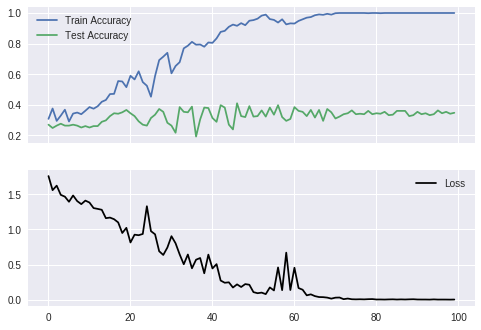

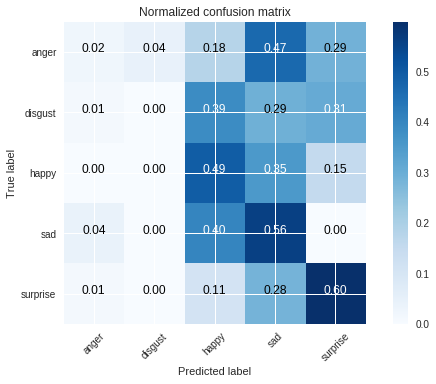

=================Part 3. Running Network===============
Epoch: 0
Train Acc: 0.2695883134130146 Test Acc: 0.2608695652173913 Loss: 2.096564292907715
Epoch: 1
Train Acc: 0.30278884462151395 Test Acc: 0.2484472049689441 Loss: 1.8126469850540161
Epoch: 2
Train Acc: 0.3054448871181939 Test Acc: 0.2670807453416149 Loss: 1.597697377204895
Epoch: 3
Train Acc: 0.3333333333333333 Test Acc: 0.22981366459627328 Loss: 1.4410789012908936
Epoch: 4
Train Acc: 0.3758300132802125 Test Acc: 0.2577639751552795 Loss: 1.3287055492401123
Epoch: 5
Train Acc: 0.38645418326693226 Test Acc: 0.2329192546583851 Loss: 1.275886058807373
Epoch: 6
Train Acc: 0.3837981407702523 Test Acc: 0.2453416149068323 Loss: 1.392107605934143
Epoch: 7
Train Acc: 0.4249667994687915 Test Acc: 0.2888198757763975 Loss: 1.1653456687927246
Epoch: 8
Train Acc: 0.43293492695883135 Test Acc: 0.2919254658385093 Loss: 1.1904609203338623
Epoch: 9
Train Acc: 0.49800796812749004 Test Acc: 0.2701863354037267 Loss: 1.1052418947219849
Epoch: 10
Tra

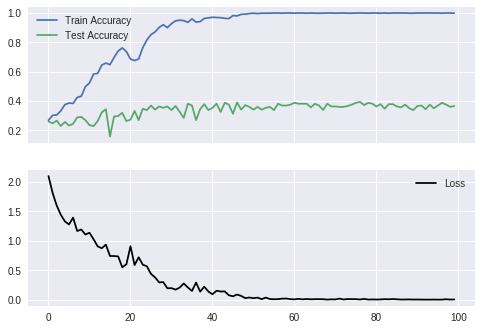

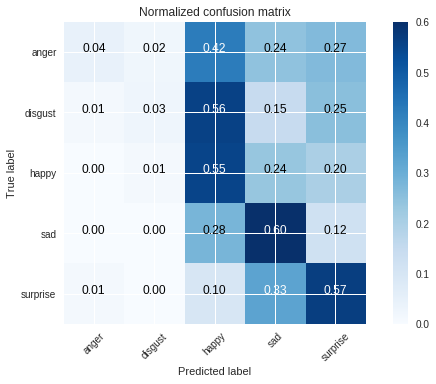

Train x shape :  (753, 1, 128, 98)
Test x shape :  (322, 1, 128, 98)
=================Part 2. Preparing Network===============
=================Part 3. Running Network===============
Epoch: 0
Train Acc: 0.32138114209827356 Test Acc: 0.14596273291925466 Loss: 2.03964900970459
Epoch: 1
Train Acc: 0.29880478087649404 Test Acc: 0.2484472049689441 Loss: 1.8533506393432617
Epoch: 2
Train Acc: 0.33200531208499334 Test Acc: 0.2111801242236025 Loss: 1.6709340810775757
Epoch: 3
Train Acc: 0.32669322709163345 Test Acc: 0.2919254658385093 Loss: 1.7070647478103638
Epoch: 4
Train Acc: 0.3745019920318725 Test Acc: 0.2360248447204969 Loss: 1.6485707759857178
Epoch: 5
Train Acc: 0.351925630810093 Test Acc: 0.2826086956521739 Loss: 1.7017098665237427
Epoch: 6
Train Acc: 0.3466135458167331 Test Acc: 0.2515527950310559 Loss: 1.5913437604904175
Epoch: 7
Train Acc: 0.3745019920318725 Test Acc: 0.2795031055900621 Loss: 1.604190707206726
Epoch: 8
Train Acc: 0.36387782204515273 Test Acc: 0.2919254658385093 Los

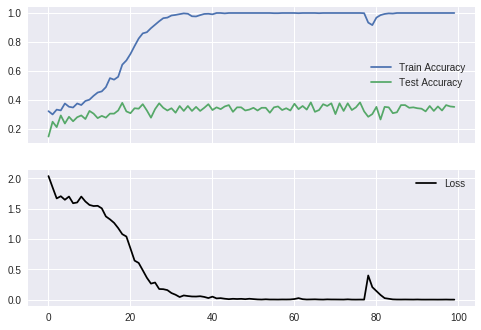

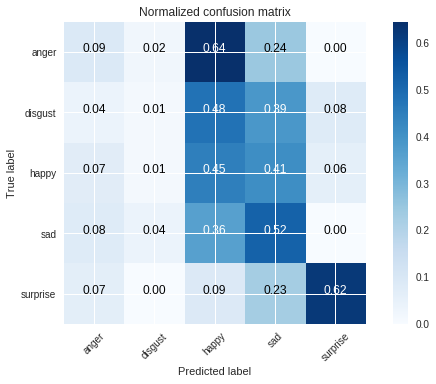

=================Part 3. Running Network===============
Epoch: 0
Train Acc: 0.2921646746347942 Test Acc: 0.16770186335403728 Loss: 2.1911559104919434
Epoch: 1
Train Acc: 0.2815405046480744 Test Acc: 0.2701863354037267 Loss: 2.2852883338928223
Epoch: 2
Train Acc: 0.35325365205843295 Test Acc: 0.2391304347826087 Loss: 1.731581211090088
Epoch: 3
Train Acc: 0.3466135458167331 Test Acc: 0.2515527950310559 Loss: 1.9763551950454712
Epoch: 4
Train Acc: 0.37317397078353254 Test Acc: 0.2577639751552795 Loss: 1.7592741250991821
Epoch: 5
Train Acc: 0.38114209827357237 Test Acc: 0.2608695652173913 Loss: 1.6691980361938477
Epoch: 6
Train Acc: 0.38778220451527223 Test Acc: 0.2732919254658385 Loss: 1.5441617965698242
Epoch: 7
Train Acc: 0.448871181938911 Test Acc: 0.2795031055900621 Loss: 1.56751549243927
Epoch: 8
Train Acc: 0.45683930942895085 Test Acc: 0.2888198757763975 Loss: 1.2772607803344727
Epoch: 9
Train Acc: 0.5205843293492696 Test Acc: 0.2826086956521739 Loss: 1.4676939249038696
Epoch: 10
Tr

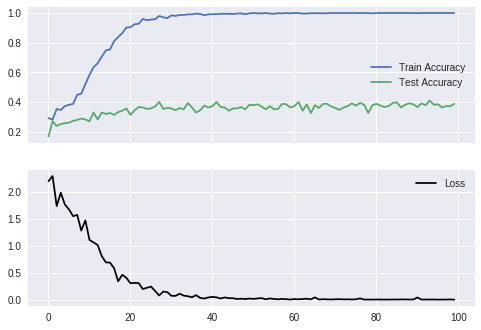

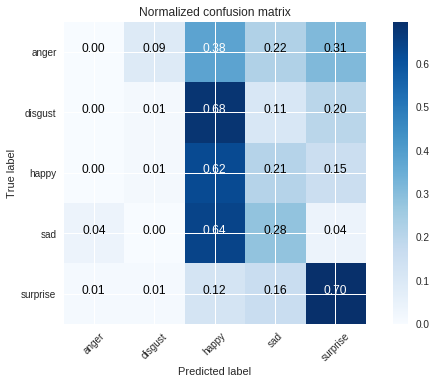

In [639]:
run= True
# if h_testing = True -> train women on women, False -> train women on men. Serves as control 

if run:
    learning_rate= 0.00005
    loc= "data"
    batch_size= 100
    max_epochs= 100
    scale= 1/5
    graytocolor= False

    h_testing= True

    printheader("Part 1. Loading Data")
    train_dir= "Emotion Data/women"
    test_dir= "Emotion Data/men"


    #for google drive only
    test_y, test_x, train_y, train_x = prepare_data(train_dir, test_dir, largeset= False)


    print(train_x.shape)
    print(test_x.shape)
if run:
  for h_testing in [True, False]:
    batch_size = 100
    learning_rate = 0.00005
  
    

    #for hyperparameter testing only
    if h_testing:
      t= int(0.3*train_y.shape[0])
      test_y= train_y[:t]
      test_x= train_x[:t]
      train_y= train_y[t:]
      train_x= train_x[t:]
    else:
      test_y, test_x= shuffle(test_y, test_x, random_state=0)
      train_y, train_x= shuffle(train_y, train_x, random_state=0)

    print("Train x shape : ", train_x.shape)
    print("Test x shape : ", test_x.shape)


    #train_x, train_y= add_noise_data(train_x, train_y)



    printheader("Part 2. Preparing Network")
    df= pd.DataFrame(index= range(max_epochs), columns= ['Train Accuracy', 'Test Accuracy', 'Loss'])


    params= {'batch_size': batch_size}    

    train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
    test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

    #true iff resnet50
    if graytocolor: 
      train_x= gray_to_color(train_x)
      test_x= gray_to_color(test_x)


    #specify network
    net= AlexNet()

    if use_gpu: 
      net= net.cuda()

    #define training dataset
    train_set= Dataset(X= train_x, y= train_y)
    train_load= DataLoader(train_set, **params)

    #define test set
    test_set= Dataset(X= test_x, y= test_y)
    test_load= DataLoader(test_set, batch_size= test_y.shape[0])


    #specify loss
    criterion= nn.CrossEntropyLoss()


    #specify optimization
    optimizer= optim.Adam(net.parameters(), lr= learning_rate)

    printheader("Part 3. Running Network")

    #uncomment below to run
    df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer, max_epochs= max_epochs)
    df.to_csv("%s/output/alexnet_out%s.csv"%(drive_dir, str(h_testing)))

    printheader("Part 4. Plotting Data")
    plot_fig(df, savename= "%s/output/alexnet_plot%s.png"%(drive_dir, str(h_testing)))


    print(labels)
    print(pred)
    cnf_matrix = confusion_matrix(labels, pred)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=class_names, 
                          savename="%s/output/alexnet_cm%s.png"%(drive_dir, str(h_testing)),
                          normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

    learning_rate = 0.0001

    #specify network
    net= MiniNet()

    if use_gpu: 
      net= net.cuda()

    #define training dataset
    train_set= Dataset(X= train_x, y= train_y)
    train_load= DataLoader(train_set, **params)

    #define test set
    test_set= Dataset(X= test_x, y= test_y)
    test_load= DataLoader(test_set, batch_size= test_y.shape[0])


    #specify loss
    criterion= nn.CrossEntropyLoss()


    #specify optimization
    optimizer= optim.Adam(net.parameters(), lr= learning_rate)

    printheader("Part 3. Running Network")

    #uncomment below to run
    df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer, max_epochs= max_epochs)
    df.to_csv("%s/output/mininet_out%s.csv"%(drive_dir, str(h_testing)))

    printheader("Part 4. Plotting Data")
    plot_fig(df, savename= "%s/output/mininet_plot%s.png"%(drive_dir, str(h_testing)))


    print(labels)
    print(pred)
    cnf_matrix = confusion_matrix(labels, pred)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=class_names, 
                          savename="%s/output/mininet_cm%s.png"%(drive_dir, str(h_testing)),
                          normalize=True,
                          title='Normalized confusion matrix')
    plt.show()



# Experiment 2: Train on Peak, Test on Mid

In [0]:
    #%% Main code body
run= False
if run: 
    learning_rate= 0.00005
    loc= "data"
    batch_size= 100
    max_epochs= 100
    scale= 1/5
    graytocolor= False

    h_testing= True

    printheader("Part 1. Loading Data")
    train_dir= "Emotion Data/women"
    test_dir= "Emotion Data/men"




    #for google drive only
    test_y, test_x, train_y, train_x = prepare_data(train_dir, test_dir, 
                                        test_y= 'mid_y.npy', test_x= 'mid_x.npy', 
                                        train_y= 'peak_y.npy', train_x= 'peak_x.npy')




    for h_testing in [False]:
        test_y, test_x= shuffle(test_y, test_x, random_state=0)
        train_y, train_x= shuffle(train_y, train_x, random_state=0)
        
        #for hyperparameter testing only
        if h_testing:
          t= int(0.3*train_y.shape[0])
          test_y= train_y[:t]
          test_x= train_x[:t]
          train_y= train_y[t:]
          train_x= train_x[t:]
          





        print("Train x shape : ", train_x.shape)
        print("Test x shape : ", test_x.shape)


        #train_x, train_y= add_noise_data(train_x, train_y)



        printheader("Part 2. Preparing Network")
        df= pd.DataFrame(index= range(max_epochs), columns= ['Train Accuracy', 'Test Accuracy', 'Loss'])


        params= {'batch_size': batch_size}    

        train_x= np.reshape(train_x, (train_x.shape[0], 1, int(640* scale), int(490*scale)))
        test_x= np.reshape(test_x, (test_x.shape[0], 1, int(640* scale), int(490*scale)))

        #true iff resnet50
        if graytocolor: 
          train_x= gray_to_color(train_x)
          test_x= gray_to_color(test_x)


        #specify network
        net= AlexNet()

        if use_gpu: 
          net= net.cuda()

        #define training dataset
        train_set= Dataset(X= train_x, y= train_y)
        train_load= DataLoader(train_set, **params)

        #define test set
        test_set= Dataset(X= test_x, y= test_y)
        test_load= DataLoader(test_set, batch_size= test_y.shape[0])


        #specify loss
        criterion= nn.CrossEntropyLoss()


        #specify optimization
        optimizer= optim.Adam(net.parameters(), lr= learning_rate)

        printheader("Part 3. Running Network")

        #uncomment below to run
        df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer, max_epochs= max_epochs)
        df.to_csv("%s/output2/alexnet_out%s.csv"%(drive_dir, str(h_testing)))

        printheader("Part 4. Plotting Data")
        plot_fig(df, savename= "%s/output2/alexnet_plot%s.png"%(drive_dir, str(h_testing)))


        print(labels)
        print(pred)
        cnf_matrix = confusion_matrix(labels, pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=class_names, 
                              savename="%s/output2/alexnet_cm%s.png"%(drive_dir, str(h_testing)),
                              normalize=True,
                              title='Normalized confusion matrix')
        plt.show()



        learning_rate= 0.0001

        #specify network
        net= MiniNet()

        if use_gpu: 
          net= net.cuda()

        #define training dataset
        train_set= Dataset(X= train_x, y= train_y)
        train_load= DataLoader(train_set, **params)

        #define test set
        test_set= Dataset(X= test_x, y= test_y)
        test_load= DataLoader(test_set, batch_size= test_y.shape[0])


        #specify loss
        criterion= nn.CrossEntropyLoss()


        #specify optimization
        optimizer= optim.Adam(net.parameters(), lr= learning_rate)

        printheader("Part 3. Running Network")

        #uncomment below to run
        df, pred, labels= run_epochs(df, train_load, test_load, net, criterion, optimizer, max_epochs= max_epochs)
        df.to_csv("%s/output2/mininet_out%s.csv"%(drive_dir, str(h_testing)))

        printheader("Part 4. Plotting Data")
        plot_fig(df, savename= "%s/output2/mininet_plot%s.png"%(drive_dir, str(h_testing)))


        print(labels)
        print(pred)
        cnf_matrix = confusion_matrix(labels, pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=class_names, 
                              savename="%s/output2/mininet_cm%s.png"%(drive_dir, str(h_testing)),
                              normalize=True,
                              title='Normalized confusion matrix')
        plt.show()



